# Feature Extraction

Prepare text annotated with time and class names.

1. Prepare tab-delimited text separated by KFold.
    1. The train text is the annotation information of the training data.
    1. The test text is the file name of the validation data.
    1. The evaluate text is the annotation information of test.txt.
1. Output
    1. X_train, Y_train
        * Dimensionality reduction using Melspectrogram
        * Concat the files in the order they were loaded.
        * Label Y for each frame (each line).
    1. Label Y_train and Y_test not one-hot, but for 4 classes, output as follows:
        * Class 0 → 1000
        * Class 1 → 0100
        * Classes 1 and 2 → 0110
        * Classes 0, 2, and 3 → 1011

In [ ]:
import wave
import numpy as np
import utils
import librosa
from IPython import embed
import os
from sklearn import preprocessing


def load_audio(filename, mono=True, fs=44100):

    file_base, file_extension = os.path.splitext(filename)
    if file_extension == '.wav':
        _audio_file = wave.open(filename)

        # Audio info
        sample_rate = _audio_file.getframerate()
        sample_width = _audio_file.getsampwidth()
        number_of_channels = _audio_file.getnchannels()
        number_of_frames = _audio_file.getnframes()

        # Read raw bytes
        data = _audio_file.readframes(number_of_frames)
        _audio_file.close()

        # Convert bytes based on sample_width
        num_samples, remainder = divmod(len(data), sample_width * number_of_channels)
        if remainder > 0:
            raise ValueError('The length of data is not a multiple of sample size * number of channels.')
        if sample_width > 4:
            raise ValueError('Sample size cannot be bigger than 4 bytes.')

        if sample_width == 3:
            # 24 bit audio
            a = np.empty((num_samples, number_of_channels, 4), dtype=np.uint8)
            raw_bytes = np.fromstring(data, dtype=np.uint8)
            a[:, :, :sample_width] = raw_bytes.reshape(-1, number_of_channels, sample_width)
            a[:, :, sample_width:] = (a[:, :, sample_width - 1:sample_width] >> 7) * 255
            audio_data = a.view('<i4').reshape(a.shape[:-1]).T
        else:
            # 8 bit samples are stored as unsigned ints; others as signed ints.
            dt_char = 'u' if sample_width == 1 else 'i'
            a = np.fromstring(data, dtype='<%s%d' % (dt_char, sample_width))
            audio_data = a.reshape(-1, number_of_channels).T

        if mono:
            # Down-mix audio
            audio_data = np.mean(audio_data, axis=0)

        # Convert int values into float
        audio_data = audio_data / float(2 ** (sample_width * 8 - 1) + 1)

        # Resample
        if fs != sample_rate:
            audio_data = librosa.core.resample(audio_data, sample_rate, fs)
            sample_rate = fs

        return audio_data, sample_rate
    return None, None

# ロードしたテキストをタブでセパレート
def load_desc_file(_desc_file):
    _desc_dict = dict()
    for line in open(_desc_file):
        words = line.strip().split('\t')
        name = words[0].split('/')[-1]
        if name not in _desc_dict:
            _desc_dict[name] = list()
        _desc_dict[name].append([float(words[2]), float(words[3]), __class_labels[words[-1]]])
    return _desc_dict


def cal_adjusted_rms(clean_rms, snr):
    a = float(snr) / 20
    noise_rms = clean_rms / (10**a)
    return noise_rms
def cal_rms(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))

def extract_mbe(_y, _sr, _nfft, _nb_mel, snr, nkind):
    y = _y
    if nkind == "white":
    #ロードしたwavと同じ時間のホワイトノイズ作成
        stop = y.shape[0]/_sr
        x1=np.linspace(0, stop, y.shape[0])
        A=0.5
        noise_wav = np.random.rand(y.shape[0])-A

        clean_amp = y #振幅値取得
        noise_amp = noise_wav #振幅値取得
        start = random.randint(0, len(noise_amp)-len(clean_amp)) #切り出し
        clean_rms = cal_rms(clean_amp) #RMS取得
        split_noise_amp = noise_amp[start: start + len(clean_amp)]
        noise_rms = cal_rms(split_noise_amp) #RMS取得

        adjusted_noise_rms = cal_adjusted_rms(clean_rms, snr) #任意のSNRになるRMSを計算
        adjusted_noise_amp = split_noise_amp * (adjusted_noise_rms / noise_rms) #任意のSNRになるnoise振幅に変換
        mixed_amp = (clean_amp + adjusted_noise_amp) #合成
        if (mixed_amp.max(axis=0) > 32767): #音割れを防ぐため16bitに正規化
            mixed_amp = mixed_amp * (32767/mixed_amp.max(axis=0))
    
    spec, n_fft = librosa.core.spectrum._spectrogram(y=mixed_amp, n_fft=_nfft, hop_length=_nfft//2, power=1)
    mel_basis = librosa.filters.mel(sr=_sr, n_fft=_nfft, n_mels=_nb_mel)
    return np.log(np.dot(mel_basis, spec))

In [ ]:
# ###################################################################
#              Main script starts here
# ###################################################################

is_mono = True
__class_labels = {
    'OT': 0,
    'APPLIX': 1,
    'TE': 2,
    'THOPAZ': 3,
    'SCD': 4,
    'PVM-high': 5,
    'C1-mid': 6
}

# location of data.
folds_list = [1, 2, 3, 4, 5]
evaluation_setup_folder = 'evaluation_setup'
audio_folder = 'audio/mealm'

# Output
feat_folder = 'feat/'
utils.create_folder(feat_folder)

# User set parameters
nfft = 1024
win_len = nfft
hop_len = win_len // 2
nb_mel_bands = 40
sr = 48000

import random
snr_ = 10 #個数
max_snr = 30
min_snr = 0
step_snr = 3
nkind = "white"
rand_snr = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
print("Random SNR:",rand_snr)

#-----------------------------------------------
# ノイズでデータオーグメンメーション
#-----------------------------------------------
print("Data augment: white noise")
for i, snr in enumerate(rand_snr):
    print(f"STEP{i} - SNR {snr}dB")

    # -----------------------------------------------------------------------
    # Feature extraction and label generation
    # -----------------------------------------------------------------------
    # Load labels
    
    train_file = os.path.join(evaluation_setup_folder, 'all_pvm-high_c1-mid_take123_fold{}_train.txt'.format(1))
    evaluate_file = os.path.join(evaluation_setup_folder, 'all_pvm-high_c1-mid_take123_fold{}_eval.txt'.format(1))
    
    desc_dict = load_desc_file(train_file)
    desc_dict.update(load_desc_file(evaluate_file)) # contains labels for all the audio in the dataset

    # Extract features for all audio files, and save it along with labels
    for audio_filename in os.listdir(audio_folder):
        audio_file = os.path.join(audio_folder, audio_filename)
        
        y, sr = load_audio(audio_file, mono=is_mono, fs=sr)
        
        mbe = None

        if is_mono:
            mbe = extract_mbe(y, sr, nfft, nb_mel_bands, snr, nkind).T
        else:
            for ch in range(y.shape[0]):
                mbe_ch = extract_mbe(y[ch, :], sr, nfft, nb_mel_bands, snr, nkind).T
                if mbe is None:
                    mbe = mbe_ch
                else:
                    mbe = np.concatenate((mbe, mbe_ch), 1)

        label = np.zeros((mbe.shape[0], len(__class_labels)))
        tmp_data = np.array(desc_dict[audio_filename])
        frame_start = np.floor(tmp_data[:, 0] * sr / hop_len).astype(int)
        frame_end = np.ceil(tmp_data[:, 1] * sr / hop_len).astype(int)
        se_class = tmp_data[:, 2].astype(int)
        for ind, val in enumerate(se_class):
            label[frame_start[ind]:frame_end[ind], val] = 1
        tmp_feat_file = os.path.join(feat_folder, 'tmp_{}_{}.npz'.format(audio_filename, 'mon' if is_mono else 'bin'))
        np.savez(tmp_feat_file, mbe, label)

    # -----------------------------------------------------------------------
    # Feature Normalization
    # -----------------------------------------------------------------------

    for fold in folds_list:
        # テキストのロード
        train_file = os.path.join(evaluation_setup_folder, 'all_pvm-high_c1-mid_take123_fold{}_train.txt'.format(fold))
        evaluate_file = os.path.join(evaluation_setup_folder, 'all_pvm-high_c1-mid_take123_fold{}_eval.txt'.format(fold))
        
        # タブでスプリット
        train_dict = load_desc_file(train_file)
        test_dict = load_desc_file(evaluate_file)

        X_train, Y_train, X_test, Y_test = None, None, None, None
        for key in train_dict.keys():
            tmp_feat_file = os.path.join(feat_folder, 'tmp_{}_{}.npz'.format(key, 'mon' if is_mono else 'bin'))
            dmp = np.load(tmp_feat_file)
            tmp_mbe, tmp_label = dmp['arr_0'], dmp['arr_1']
            if X_train is None:
                X_train, Y_train = tmp_mbe, tmp_label
            else:
                X_train, Y_train = np.concatenate((X_train, tmp_mbe), 0), np.concatenate((Y_train, tmp_label), 0)

        for key in test_dict.keys():
            tmp_feat_file = os.path.join(feat_folder, 'tmp_{}_{}.npz'.format(key, 'mon' if is_mono else 'bin'))
            dmp = np.load(tmp_feat_file)
            tmp_mbe, tmp_label = dmp['arr_0'], dmp['arr_1']
            if X_test is None:
                X_test, Y_test = tmp_mbe, tmp_label
            else:
                X_test, Y_test = np.concatenate((X_test, tmp_mbe), 0), np.concatenate((Y_test, tmp_label), 0)

        # Normalize the training data, and scale the testing data using the training data weights
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        normalized_feat_file = os.path.join(feat_folder, 'tmp_mbe_{}_snpro{}_fold{}.npz'.format('mon' if is_mono else 'bin', i, fold))
        np.savez(normalized_feat_file, X_train, Y_train, X_test, Y_test)

for fold2 in folds_list:
    for i, _ in enumerate(rand_snr):
        tmpfold_feat_file = os.path.join(feat_folder, 'tmp_mbe_{}_snpro{}_fold{}.npz'.format('mon' if is_mono else 'bin', i, fold2))
        dmp2 = np.load(tmpfold_feat_file)
        X_train_fold, Y_train_fold, X_test_fold, Y_test_fold = dmp2['arr_0'], dmp2['arr_1'], dmp2['arr_2'], dmp2['arr_3']

        if i == 0:
            X_train_con = X_train_fold
            X_test_con = X_test_fold
            Y_train_con = Y_train_fold
            Y_test_con = Y_test_fold
        else:
            X_train_con = np.concatenate([X_train_con, X_train_fold], 0)
            X_test_con = np.concatenate([X_test_con, X_test_fold], 0)
            Y_train_con = np.concatenate([Y_train_con, Y_train_fold], 0)
            Y_test_con = np.concatenate([Y_test_con, Y_test_fold], 0)

    concatenated_feat_file = os.path.join(feat_folder, 'mbe123_{}_snr_0-28_step2_fold{}.npz'.format('mon' if is_mono else 'bin', fold2))
    np.savez(concatenated_feat_file, X_train_con, Y_train_con, X_test_con, Y_test_con)
    print('concatenated_feat_file : {}'.format(concatenated_feat_file))
print("-Finished-")

Random SNR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Data augment: white noise
STEP0 - SNR 0dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP1 - SNR 2dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP2 - SNR 4dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP3 - SNR 6dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP4 - SNR 8dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP5 - SNR 10dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP6 - SNR 12dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP7 - SNR 14dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP8 - SNR 16dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP9 - SNR 18dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP10 - SNR 20dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP11 - SNR 22dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP12 - SNR 24dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP13 - SNR 26dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


STEP14 - SNR 28dB


/home/kkishi/anaconda3/envs/tf2.0/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


concatenated_feat_file : feat/mbe123_mon_snr_0-28_step2_fold1.npz
concatenated_feat_file : feat/mbe123_mon_snr_0-28_step2_fold2.npz
concatenated_feat_file : feat/mbe123_mon_snr_0-28_step2_fold3.npz
concatenated_feat_file : feat/mbe123_mon_snr_0-28_step2_fold4.npz
concatenated_feat_file : feat/mbe123_mon_snr_0-28_step2_fold5.npz
-Finished-


In [ ]:
print("X_train:", X_train.shape, "(time, freq[mel])")
print("Y_train:", Y_train.shape, "(time, class number)")
print("X_test:", X_test.shape, "(time, freq[mel])")
print("Y_test:", Y_test.shape, "(time, class number)")
print(X_train[0])

X_train: (135004, 40) (time, freq[mel])
Y_train: (135004, 7) (time, class number)
X_test: (43653, 40) (time, freq[mel])
Y_test: (43653, 7) (time, class number)
[-2.52525835 -1.32748772 -0.39503942 -0.78164415 -0.58574894 -0.70426241
 -1.67164051 -1.85312012 -1.6969132  -1.301657   -0.91845462 -1.56002226
 -0.9115674  -0.53109235 -0.39979238 -0.96126972 -1.97590036 -1.64040034
 -1.50411681 -1.62941239 -0.42794475 -0.45175109 -1.60489637 -2.20460927
 -0.89326903 -0.92950467 -1.27162956 -1.29429596 -0.26148518 -0.70842388
 -1.3005026  -1.06249495 -0.56995735 -2.4314542  -2.879973   -1.96737275
 -0.82678485 -2.92238682 -0.91791345 -1.25554223]


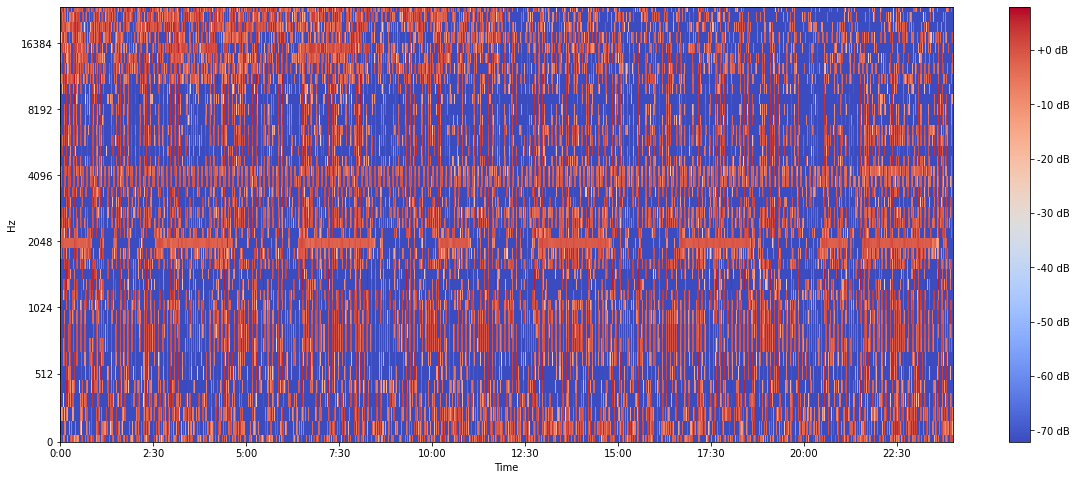

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

#スペクトログラム表示
plt.figure(figsize=(20,8))
librosa.display.specshow(librosa.power_to_db(X_train.T), x_axis='time', y_axis='mel',sr=sr, hop_length=hop_len)
plt.colorbar(format='%+2.0f dB')
plt.show()